# Notebook to examine the dependence of numerical mixing on model output frequency and the associated error of each term

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

#Dask
from dask.distributed import Client

client = Client()
client

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44538 instead
  warnings.warn(


In [3]:
# Open all output from 60 min, 30 min, 10 min frequency
#Tendency
ds2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/ds2dt_parent_ver1_2010.npy')
dsprime2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/dsprime2dt_ver1_parent_2010.npy')

#Advection
s2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltsquareadv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltvaradv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Surface
s2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/s2flux_ver1_2010_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/sprime2flux_ver1_2010_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Online resolved and numerical mixing
chi_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_ver1_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
mnum_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_ver1_2010_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Horizontal mixing 
chih = xr.open_dataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/chi_horz/chih_parent_hgrad.nc').chih_parent
chi_tot = chih+chi_online

#Horizontal diffusion
s2_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/60min/hdiffusion_vol/s2_hdiffusion_60min_*.nc').s2_diff_flux[1:-1]#xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/s2_horz/s2_horz_diff_parent_*.nc').s2_diff_flux
sprime2_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/60min/hdiffusion_vol/sprime2_hdiffusion_60min_*.nc').sprime2_diff_flux[1:-1]#xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/sprime2_horz/sprime2_horz_diff_parent_*.nc').s2_diff_flux

#Offline numerical mixing 
mnum_ss = -(ds2dt+s2_advection+chi_tot-s2_surface+s2_diff_flux)
mnum_sprime2 = -(dsprime2dt+sprime2_advection+chi_tot-sprime2_surface+sprime2_diff_flux)

#Define time for plotting
time = chi_online.ocean_time.values

#30 minutes -----------------
ds2dt_30 = np.load('/d2/home/dylan/JAMES/budget_outputs/30min/tendency/ds2dt_parent_2010_30min.npy')
dsprime2dt_30 = np.load('/d2/home/dylan/JAMES/budget_outputs/30min/tendency/dsprime2dt_parent_2010_30min.npy')

s2_advection_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/advection/saltsquareadv_parent_2010_30min_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/advection/saltvaradv_parent_2010_30min_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

s2_surface_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/surface_fluxes/s2flux_2010_30min_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/surface_fluxes/sprime2flux_2010_30min_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

chi_online_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/mixing/chi_online_2010_30min_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
mnum_online_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/mixing/mnum_online_2010_30min_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

chih_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/30min/hmix/chi_horizontal_30min_*.nc').chi_horizontal.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
chi_tot_30 = chih_30+chi_online_30

#Horizontal diffusion
s2_diff_flux_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/30min/hdiffusion_vol/s2_hdiffusion_30min_*.nc').s2_diff_flux[1:-1]#xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/30min/hdiffusion/s2_hdiffusion_30min_*.nc').s2_diff_flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_diff_flux_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/30min/hdiffusion_vol/sprime2_hdiffusion_30min_*.nc').sprime2_diff_flux[1:-1]#xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/30min/hdiffusion/sprime2_hdiffusion_30min_*.nc').s2_diff_flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

mnum_ss_30 = -(ds2dt_30+s2_advection_30+chi_tot_30-s2_surface_30+s2_diff_flux_30)
mnum_sprime2_30 = -(dsprime2dt_30+sprime2_advection_30+chi_tot_30-sprime2_surface_30+sprime2_diff_flux_30)

time_30 = chi_online_30.ocean_time.values

sbar_parent_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/sbar/sbar_parent_2010_30min_*.nc').sbar.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#10 minutes ---------------
ds2dt_10 = np.load('/d2/home/dylan/JAMES/budget_outputs/10min/ds2dt_parent_2010_10min.npy')
dsprime2dt_10 = np.load('/d2/home/dylan/JAMES/budget_outputs/10min/dsprime2dt_parent_2010_10min.npy')

s2_advection_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/advection/saltsquareadv_parent_2010_10min_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/advection/saltvaradv_parent_2010_10min_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

s2_surface_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/surface_fluxes/s2flux_2010_10min_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/surface_fluxes/sprime2flux_2010_10min_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

chi_online_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/mixing/chi_online_2010_10min_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
mnum_online_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/mixing/mnum_online_2010_10min_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

chih_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/10min/hmix/chi_horizontal_10min_*.nc').chi_horizontal.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
chi_tot_10 = chih_10+chi_online_10

s2_diff_flux_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/10min/hdiffusion_vol/s2_hdiffusion_10min_*.nc').s2_diff_flux[1:-1]#xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/10min/hdiffusion/s2_hdiffusion_10min_*.nc').s2_diff_flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_diff_flux_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/10min/hdiffusion_vol/sprime2_hdiffusion_10min_*.nc').sprime2_diff_flux[1:-1]#xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/10min/hdiffusion/sprime2_hdiffusion_10min_*.nc').s2_diff_flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

mnum_ss_10 = -(ds2dt_10+s2_advection_10+chi_tot_10-s2_surface_10+s2_diff_flux_10)
mnum_sprime2_10 = -(dsprime2dt_10+sprime2_advection_10+chi_tot_10-sprime2_surface_10+sprime2_diff_flux_10)

time_10 = chi_online_10.ocean_time.values

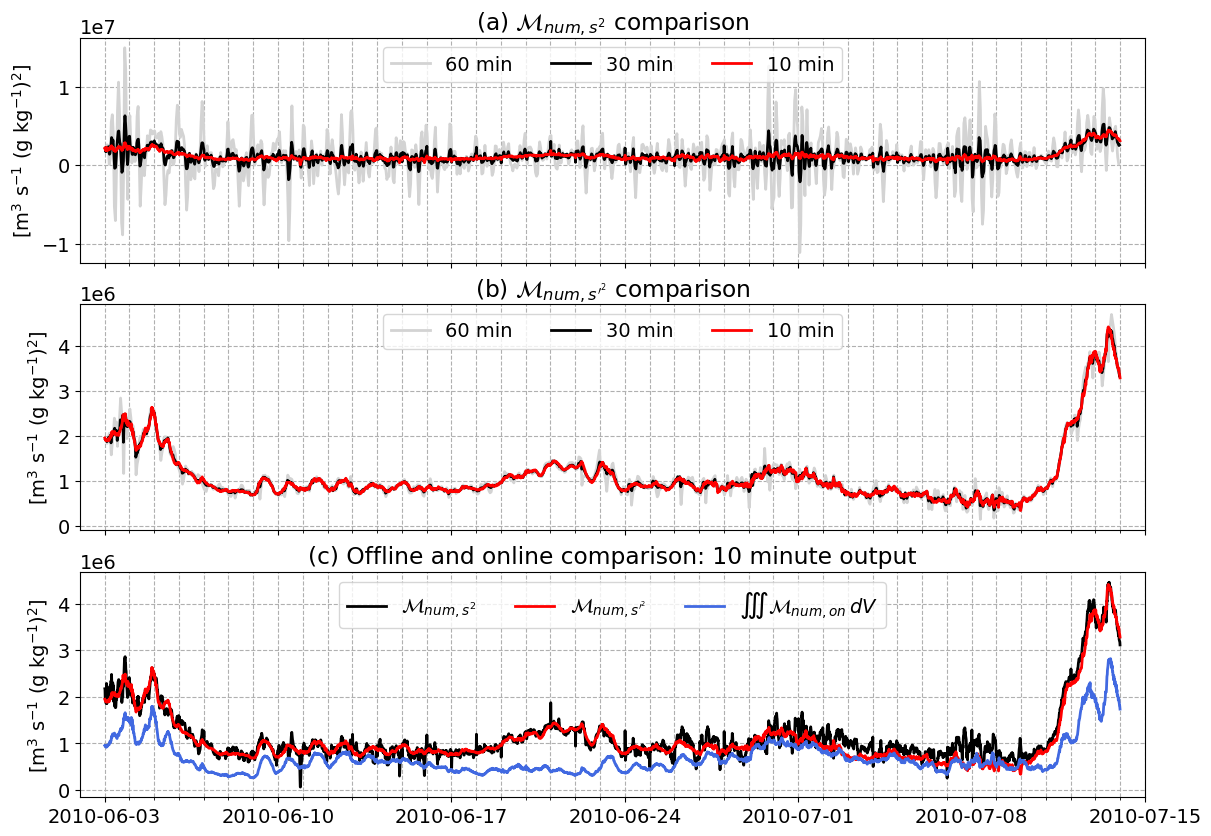

In [4]:
plt.rcParams.update({'font.size': 14})

#Format the date-ticks
myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

fig, ax = plt.subplots(3,1, figsize = (12,2.75*3), constrained_layout = True, sharey = False)

ax[0].plot(time, mnum_ss, lw = 2, c = 'lightgrey', label = r'60 min')
ax[0].plot(time_30, mnum_ss_30, lw = 2, c = 'k', label = r'30 min')
ax[0].plot(time_10, mnum_ss_10, lw = 2, c = 'r', label = r'10 min')
# ax[0].plot(time_10, mnum_online_10, lw = 2, color = 'm', label = r'$M_{num, on}}$ 10 min')
ax[0].set_title('(a) $\mathcal{M}_{num, s^2}$ comparison')
ax[0].legend(loc = 'upper center', ncol = 4)

ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[0].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[0].set_xticks(ticks = dates)
ax[0].grid(linestyle = '--')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])

ax[1].plot(time, mnum_sprime2, lw = 2, color = 'lightgrey', label = r'60 min')
ax[1].plot(time_30, mnum_sprime2_30, lw = 2, color = 'k', label = r'30 min')
ax[1].plot(time_10, mnum_sprime2_10, lw = 2, color = 'r', label = r'10 min')
# ax[1].plot(time_10, mnum_online_10, lw = 2, color = 'm', label = r'$M_{num, on}}$ 10 min')
ax[1].set_title(r'(b) $\mathcal{M}_{num, s^{\prime^2}}$ comparison')
ax[1].legend(loc = 'upper center', ncol = 4)

ax[1].xaxis.set_major_formatter(myFmt)
ax[1].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[1].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[1].grid(linestyle = '--')
ax[1].set_xticklabels([])
ax[1].set_xticks(ticks = dates)

ax[2].plot(time_10, mnum_ss_10, lw = 2, color = 'k', label = r'$\mathcal{M}_{num, s^2}$')
ax[2].plot(time_10, mnum_sprime2_10, lw = 2, color = 'r', label = r'$\mathcal{M}_{num, s^{\prime^2}}$')
ax[2].plot(time_10, mnum_online_10, lw = 2, color = 'royalblue', label = '$\iiint \mathcal{M}_{num, on} \, dV$')
ax[2].set_title(r'(c) Offline and online comparison: 10 minute output')
ax[2].legend(loc = 'upper center', ncol = 3)

ax[2].xaxis.set_major_formatter(myFmt)
ax[2].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[2].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[2].set_xticks(ticks = dates)
ax[2].grid(linestyle = '--')
# ax[2].set_xlabel('Time [month-day 2010]')

for i in range(3):
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    minor_locator = AutoMinorLocator(7)
    ax[i].yaxis.grid(True, linestyle = '--')
    ax[i].xaxis.set_minor_locator(minor_locator)
    ax[i].xaxis.grid(True, which = 'both', linestyle = '--')
    
# plt.savefig('temporal_resolution_budgets_revised.jpg', dpi = 300, bbox_inches='tight')